In [ ]:
!wget https://www.mbu.ac.th/wp-content/uploads/2021/12/th-sarabun-psk.zip --no-check-certificate
!mkdir /usr/share/fonts/truetype/th-sarabun-psk/
!unzip -q /content/th-sarabun-psk.zip -d /usr/share/fonts/truetype/th-sarabun-psk/

In [ ]:
! pip install pynini spacy spacy-pythainlp deepcut transformers sentencepiece

# Preprocessing Thai words

In [ ]:
import spacy
import pythainlp
import spacy_pythainlp.core
from spacy.language import Language
from spacy.util import filter_spans
from spacy.matcher import Matcher, PhraseMatcher
from pythainlp.util.time import thaiword_to_time, thaiword_to_num, num_to_thaiword

In [ ]:
class VerbRetokenizer:
    def __init__(self, nlp, patterns):
        self.patterns = patterns
        self.matcher = Matcher(nlp.vocab)
        for name, pattern in self.patterns.items():
          self.matcher.add(name, [pattern])

    def __call__(self, doc):
        matches = self.matcher(doc)
        spans = list(reversed(filter_spans([doc[start:end] for _, start, end in matches])))
        with doc.retokenize() as retokenizer:
          for span in spans:
              retokenizer.merge(doc[span.start:span.end])
        return doc
"""
Retokenizing separated "ปิดไฟ" , "เปิดไฟ" intent
"""
@Language.factory("verb_retokenize")
def verb_retokenize(nlp, name, patterns: dict):
    return VerbRetokenizer(nlp, patterns)

In [ ]:
class PrepRetokenizer:
    def __init__(self, nlp, patterns, prefix):
        self.nlp, self.patterns, self.prefix = nlp, patterns, prefix
        self.matcher = Matcher(nlp.vocab)
        for name, pattern in self.patterns.items():
          self.matcher.add(name, [pattern], greedy="LONGEST")

    def __call__(self, doc):
        matches = self.matcher(doc)
        spans = list(reversed([(cls, doc[start:end]) for cls, start, end in matches]))

        with doc.retokenize() as retokenizer:
          for cls, span in spans:
            if self.prefix:
              prefix = self.nlp.vocab.strings[cls]
              heads  = [(doc[span.start],1),doc[span.start-1]]
              content =  span.text.replace(prefix,'')

              parent_pos = doc[span.start].pos_
              attrs   = {"POS": ["ADP", parent_pos]}
              retokenizer.split(doc[span.start], [prefix, content], heads, attrs)
            else:
              postfix = self.nlp.vocab.strings[cls]
              heads  = [(doc[span.start],1),doc[span.start-1]]
              content =  span.text.replace(postfix,'')

              parent_pos = doc[span.start].pos_
              attrs   = {"POS": [parent_pos, "ADP"]}
              retokenizer.split(doc[span.start], [content, postfix], heads, attrs)
        return doc

"""
Retokenizing ambigious preposition due to thai character clustering algorithm
"""
@Language.factory("prefix_retokenize")
def prep_retokenize(nlp, name, patterns: dict):
    return PrepRetokenizer(nlp, patterns, prefix=True)
@Language.factory("postfix_retokenize")
def prep_retokenize(nlp, name, patterns: dict):
    return PrepRetokenizer(nlp, patterns, prefix=False)

In [ ]:
class NumRetokenizer:
    def __init__(self, nlp, lengths):
        self.lengths = lengths
        numbers = [num_to_thaiword(i) for i in range(0,self.lengths+1)]
        self.matcher = PhraseMatcher(nlp.vocab)

        for num in numbers:
          self.matcher.add(num, [nlp(num)])

    def __call__(self, doc):
        matches = self.matcher(doc)
        spans = list(reversed(filter_spans([doc[start:end] for _, start, end in matches])))
        with doc.retokenize() as retokenizer:
          for span in spans:
              attrs = {"POS": "NUM"}
              retokenizer.merge(doc[span.start:span.end], attrs)
        return doc

"""
Retokenizing ambigious numeric word up to specific number
"""
@Language.factory("num_retokenize", default_config={"lengths": 1000})
def num_retokenize(nlp, name, lengths: int):
    return NumRetokenizer(nlp, lengths=lengths)

In [ ]:
"""
https://github.com/PyThaiNLP/spaCy-PyThaiNLP/blob/main/spacy_pythainlp/core.py
"""
class CustomNerComponent:
    def __init__(self, nlp, engine_name):
      self.engine_name = engine_name
      if  self.engine_name == 'wangchanberta':
        from pythainlp.wangchanberta import NamedEntityRecognition as Ner
        self.engine = Ner()
      if  self.engine_name == 'thainer':
        from pythainlp.tag.thainer import ThaiNameTagger as Ner
        self.engine = Ner()

    def __call__(self, doc):
        _list_txt = []
        if doc.has_annotation("SENT_START"):
            _list_txt = [i.text for i in list(doc.sents)]
        else:
            _list_txt = [j.text for j in doc]
        _ner_ =[]
        for i in _list_txt:
            if  self.engine_name == 'wangchanberta':
              _ner_.extend(self.engine.get_ner(i))
            else:
              _ner_.extend(self.engine.get_ner(i, pos=False))
        _new_ner = []
        c=0
        _t=""

        for i,(w, tag) in enumerate(_ner_):
            len_w = len(w)
            if tag.startswith("B-") and _t == tag.replace("B-",""):
                _new_ner[-1][0] = c             # Don't allow two consecutive  beginning to occur at the same time
            if i+1 == len(_ner_) and _t != "":
                _new_ner[-1][1] = c+len_w
            elif i+1 == len(_ner_) and tag.startswith("B-"):
                _t =  tag.replace("B-","")
                _new_ner.append([c,c+len_w,_t])
            elif tag.startswith("B-") and _t=="":
                _t = tag.replace("B-","")
                _new_ner.append([c,None,_t])
            elif tag.startswith("B-") and _t!="":
                _new_ner[-1][1] = c
                _t =  tag.replace("B-","")
                _new_ner.append([c,None,_t])
            elif tag == "O" and _t!="":
                _new_ner[-1][1] = c
                _t=""
            c+=len_w
        _ents = []
        for start, end, label in _new_ner:
            span = doc.char_span(start-1, end, label=label, alignment_mode="contract")
            if span is None:
                pass
            else:
                _ents.append(span)

        doc.ents = _ents
        return doc

"""
Customizing NERs component supporting WanChanBerta Model
"""
@Language.factory("named_entity_recognition", default_config={"engine_name": "wangchanberta"})
def ner(nlp, name, engine_name: str):
    return CustomNerComponent(nlp,  engine_name=engine_name)

In [ ]:
nlp = spacy.blank('th')
nlp.add_pipe(
   "pythainlp",
   config={
      "pos": True,
      "pos_engine": "perceptron",
      "sent":True,
      "ner_engine": "thainer",  # [ "thainer"]
      "ner": False,
      "tokenize": True,
      "tokenize_engine":"newmm" # ["newmm","deepcut","nercut"]
   }
)
verb_patterns = {"ปิดไฟ":[{"TEXT": "ปิด"}, {"TEXT": "ไฟ"}], "เปิดไฟ":[{"TEXT": "เปิด"}, {"TEXT": "ไฟ"}], "ห้องนำ้":[{"TEXT": "ห้อง"}, {"TEXT": "นำ้"}]}
prefix  = ['บน','ล่าง','หน้า','หลัง','ซ้าย','ขวา','ที่','ใน','บริเวณ','เเถว','ข้าง']
postfix = ['บน','ล่าง','หน้า','หลัง','ซ้าย','ขวา']
prefix_patterns  = {"ไฟ":[{"TEXT": {"REGEX": "^ไฟ.*$"}}]} | {word:[{"TEXT": {"REGEX": f"^{word}[^\s].*$"}}] for word in prefix}
postfix_patterns = {word:[{"TEXT": {"REGEX": f"^[^\sไฟ].*{word}$"}}] for word in postfix}

### Required Components
nlp.add_pipe("prefix_retokenize", config={"patterns": prefix_patterns})
nlp.add_pipe("postfix_retokenize", config={"patterns": postfix_patterns})
nlp.add_pipe("verb_retokenize", config={"patterns": verb_patterns})
nlp.add_pipe("named_entity_recognition",  config={"engine_name": "wangchanberta"})
nlp.add_pipe("num_retokenize", config={"lengths": 100})
## Optional Components
nlp.add_pipe("merge_entities")

# List all the pipeline components
pipeline_components = nlp.pipe_names

# Print the list of pipeline components
print("Pipeline components:", pipeline_components)

In [ ]:
nlp_backoff = spacy.blank('th')
nlp_backoff.add_pipe(
   "pythainlp",
   config={
      "pos": True,
      "pos_engine": "perceptron",
      "sent":True,
      "ner_engine": "thainer",  # [ "thainer"]
      "ner": False,
      "tokenize": True,
      "tokenize_engine":"newmm" # ["newmm","deepcut","nercut"]
   }
)
verb_patterns = {"ปิดไฟ":[{"TEXT": "ปิด"}, {"TEXT": "ไฟ"}], "เปิดไฟ":[{"TEXT": "เปิด"}, {"TEXT": "ไฟ"}], "ห้องนำ้":[{"TEXT": "ห้อง"}, {"TEXT": "นำ้"}]}
prefix  = ['บน','ล่าง','หน้า','หลัง','ซ้าย','ขวา','ที่','ใน','บริเวณ','เเถว','ข้าง']
postfix = ['บน','ล่าง','หน้า','หลัง','ซ้าย','ขวา']
prefix_patterns  = {"ไฟ":[{"TEXT": {"REGEX": "^ไฟ.*$"}}]} | {word:[{"TEXT": {"REGEX": f"^{word}[^\s].*$"}}] for word in prefix}
postfix_patterns = {word:[{"TEXT": {"REGEX": f"^[^\sไฟ].*{word}$"}}] for word in postfix}

### Required Components
nlp_backoff.add_pipe("prefix_retokenize", config={"patterns": prefix_patterns})
nlp_backoff.add_pipe("postfix_retokenize", config={"patterns": postfix_patterns})
nlp_backoff.add_pipe("verb_retokenize", config={"patterns": verb_patterns})
nlp_backoff.add_pipe("named_entity_recognition",  config={"engine_name": "wangchanberta"})
nlp_backoff.add_pipe("num_retokenize", config={"lengths": 100})
## Optional Components
# nlp_backoff.add_pipe("merge_entities")

# List all the pipeline components
pipeline_components = nlp_backoff.pipe_names

# Print the list of pipeline components
print("Pipeline components:", pipeline_components)

Pipeline components: ['pythainlp', 'prefix_retokenize', 'postfix_retokenize', 'verb_retokenize', 'named_entity_recognition', 'num_retokenize']


# Rule based Grammar

In [ ]:
from subprocess import check_call
from IPython.display import Image
import pynini as pn
from copy import deepcopy
from datetime import time, datetime
from pythainlp.util import num_to_thaiword, thai_strptime, thai_strftime

In [ ]:
def add_symbols_from_list(table, vocabs):
    for word in vocabs:
      table.add_symbol(word)

In [ ]:
def add_multiple_arc(F, current_state, next_state, insym, outsym):
   sym_pairs = list(zip(insym, outsym))
   for idx, (insym, outsym) in enumerate(sym_pairs):
      F.add_arc(current_state, pn.Arc(state_table.find(insym), action_table.find(outsym), None, next_state))

In [ ]:
class LightNLUWFSTBuilder:
    def __init__(self):
      """
      Defaults state for WFST:
      '<eps>' :Non emitting input/output state
      '<vrb>' :Verb Pos Tagging
      '<oth>' :Other tokens
      '<unk>' :Unknown Location Entity
      '<time>':Time Entity
      '<num>' :Number Entity

      'command/LightON' : command attribute showing that LightON
      'command/LightOFF': command attribute showing that LightOFF
      'location/UnknownEntity': location attribute for unregistered entity
      'time/TimeConverter'    : time attribute for Triggering TimeConverter function
      'time/MinConverter'     : time attribute for Triggering MinConverter function
      'time/Reset'            : time attribute for Triggering time Reset function
      'time/Hour'             : time attribute for storing hour values ex.time/Hour/[1-12]
      'time/HourType'         : time attribute for storing hour types ex.time/HourType/[AM-PM]

      """
      self.states = ['<eps>', '<vrb>', '<oth>', '<unk>', '<time>', '<num>', 'เปิดไฟ', 'ปิดไฟ']
      self.actions = ['<eps>', 'command/LightON', 'command/LightOFF', 'location/UnknownEntity',
                'time/TimeConverter', 'time/Reset', 'time/Hour', 'time/HourType', 'time/MinConverter']

      # defining specific vocabulary for constructing sentence
      self.registered_location = {'ห้องนั่งเล่น':'LivingRoom', 'ห้องนอน':'Bedroom', 'ห้องโถง':'Hall', 'ห้องทำงาน':'Workshop',
                            'โรงรถ':'Garage', 'โถง':'Hall', 'บ้าน':'House', 'ออฟฟิศ':'Office', 'ห้องนำ้':'Bathroom', 'เตียงนอน':'Bed', 'หัวนอน': 'Bedlamp'}
      self.registered_prefix = {'บน':'Top', 'ล่าง':'Bottom', 'หน้า':'Front', 'หลัง':'Back', 'ซ้าย':'Left', 'ขวา':'Right',
                                'ที่':'At' , 'ใน':'In', 'บริเวณ':'Within', 'เเถว':'Around', 'ข้าง':'Near'}

    def add_symbols_to_table(self, state_table, action_table):
      # defining important state-action symbol
      add_symbols_from_list(state_table, self.states)
      add_symbols_from_list(action_table, self.actions)

      # defining important sentence specific symbols
      preposition_insym = list(self.registered_prefix.keys())
      preposition_outsym = list(map(lambda x: "preposition/" + x, list(self.registered_prefix.values())))
      add_symbols_from_list(state_table, preposition_insym)
      add_symbols_from_list(action_table,  preposition_outsym)

      location_insym = list(self.registered_location.keys())
      location_outsym =  list(map(lambda x: "location/" + x, list(self.registered_location.values())))
      add_symbols_from_list(state_table, location_insym)
      add_symbols_from_list(action_table, location_outsym)

    def build(self, state_table, action_table, F=None, start_state=None):
      # defining WFST
      if F and start_state != -1:
        self.F = deepcopy(F)
        self.F.set_input_symbols(state_table)
        self.F.set_output_symbols(action_table)
      else:
        self.F = pn.Fst()
        start_state = self.F.add_state()
        self.F.set_start(start_state)
        self.F.set_input_symbols(state_table)
        self.F.set_output_symbols(action_table)


      # arc for start state
      self.F.add_arc(start_state, pn.Arc(state_table.find('<oth>'), action_table.find('<eps>'), None, start_state))
      next_state = self.F.add_state()

      # arc for detecting "เปิดไฟ/ปิดไฟ"
      self.F.add_arc(start_state, pn.Arc(state_table.find('ปิดไฟ'), action_table.find('command/LightOFF'), None, next_state))
      self.F.add_arc(start_state, pn.Arc(state_table.find('เปิดไฟ'), action_table.find('command/LightON'), None, next_state))
      self.F.add_arc(next_state, pn.Arc(state_table.find('<oth>'), action_table.find('<eps>'), None, next_state))
      self.F.set_final(next_state)
      intent_state = next_state
      current_state = next_state

      # arc for detecting place prefix
      next_state = self.F.add_state()
      insym = list(self.registered_prefix.keys())
      outsym = list(map(lambda x: "preposition/" + x, list(self.registered_prefix.values())))
      add_multiple_arc(self.F, current_state, next_state, insym, outsym)
      past_state = current_state
      current_state = next_state

      # arc for detecting location
      next_state = self.F.add_state()
      insym = list(self.registered_location.keys())
      outsym = list(map(lambda x: "location/" + x, list(self.registered_location.values())))
      self.F.add_arc(past_state, pn.Arc(state_table.find('<unk>'), action_table.find('location/UnknownEntity'), None, next_state))
      self.F.add_arc(current_state, pn.Arc(state_table.find('<unk>'), action_table.find('location/UnknownEntity'), None, next_state))
      self.F.add_arc(next_state, pn.Arc(state_table.find('<oth>'), action_table.find('<eps>'), None, next_state))
      add_multiple_arc(self.F, past_state, next_state, insym, outsym)
      add_multiple_arc(self.F, current_state, next_state, insym, outsym)
      self.F.set_final(next_state)
      past_state = current_state
      current_state = next_state
      return self.F, (current_state, intent_state)


In [ ]:
class TimeWFSTBuilder:
    def __init__(self):
      """
      Defaults state for WFST:
      '<eps>' :Non emitting input/output state
      '<vrb>' :Verb Pos Tagging
      '<oth>' :Other tokens
      '<unk>' :Unknown Location Entity
      '<time>':Time Entity
      '<num>' :Number Entity

      'command/LightON' : command attribute showing that LightON
      'command/LightOFF': command attribute showing that LightOFF
      'location/UnknownEntity': location attribute for unregistered entity
      'time/TimeConverter'    : time attribute for Triggering TimeConverter function
      'time/MinConverter'     : time attribute for Triggering MinConverter function
      'time/Reset'            : time attribute for Triggering time Reset function
      'time/Hour'             : time attribute for storing hour values ex.time/Hour/[1-12]
      'time/HourType'         : time attribute for storing hour types ex.time/HourType/[AM-PM]

      """
      self.states = ['<eps>', '<vrb>', '<oth>', '<unk>', '<time>', '<num>', 'เปิดไฟ', 'ปิดไฟ']
      self.actions = ['<eps>', 'command/LightON', 'command/LightOFF', 'location/UnknownEntity',
                'time/TimeConverter', 'time/Reset', 'time/Hour', 'time/HourType', 'time/MinConverter']

      # defining specific vocabulary for constructing sentence
      self.registered_location = {'ห้องนั่งเล่น':'LivingRoom', 'ห้องนอน':'Bedroom', 'ห้องโถง':'Hall', 'ห้องทำงาน':'Workshop',
                            'โรงรถ':'Garage', 'โถง':'Hall', 'บ้าน':'House', 'ออฟฟิศ':'Office', 'ห้องนำ้':'Bathroom', 'เตียงนอน':'Bed', 'หัวนอน': 'Bedlamp'}
      self.registered_prefix = {'บน':'Top', 'ล่าง':'Bottom', 'หน้า':'Front', 'หลัง':'Back', 'ซ้าย':'Left', 'ขวา':'Right',
                                'ที่':'At' , 'ใน':'In', 'บริเวณ':'Within', 'เเถว':'Around', 'ข้าง':'Near'}

      # defining time specific vocabulary
      self.rhs_six_clock = {'โมง':'1', 'หนึ่ง':'1', 'สอง':'2', 'สาม':'3', 'สี่':'4', 'ห้า':'5', 'หก':'6'}
      self.lhs_six_clock = {'เจ็ด':'7','เเปด':'8', 'เก้า':'9', 'สิบ':'10', 'สิบเอ็ด':'11', 'สิบสอง':'12'}

      self.rhs_half_clock = {'สิบสาม':'13', 'สิบสี่':'14', 'สิบห้า':'15', 'สิบหก':'16', 'สิบเจ็ด':'17', 'สิบเเปด':'18',
                             'สิบเก้า':'19', 'ยี่สิบ':'20', 'ยี่สิบเอ็ด':'21', 'ยี่สิบสอง':'22', 'ยี่สิบสาม':'23', 'ยี่สิบสี่':'24'}
      self.time_quote     = {'โมง':'24h', 'นาฬิกา':'24h', 'เช้า':'AM', 'เที่ยง':'AM', 'ตอนเที่ยง':'AM', 'บ่าย':'PM', 'ตอนบ่าย':'PM',
                             'เย็น':'PM', 'ทุ่ม':'PM(ทุ่ม)', 'คืน':'PM', 'ตี':'AM', 'ตอนตี':'AM'}
      self.lhs_half_clock = self.rhs_six_clock | self.lhs_six_clock
      self.full_clock     = self.lhs_half_clock | self.rhs_half_clock

    def add_symbols_to_table(self, state_table, action_table):
      # defining important state-action symbol
      add_symbols_from_list(state_table, self.states)
      add_symbols_from_list(action_table, self.actions)

      # defining important time specific symbol
      hour_insym  = list(self.full_clock.keys())
      hour_outsym = list(map(lambda x: "time/Hour/" + x, list(self.full_clock.values())))
      add_symbols_from_list(state_table, hour_insym)
      add_symbols_from_list(action_table, hour_outsym)

      # defining important minute specific symbol
      num_list = list(range(1,61))
      minute_insym = [num_to_thaiword(i) for i in num_list]
      minute_outsym = [str(i) for i in num_list]
      add_symbols_from_list(state_table, minute_insym)
      add_symbols_from_list(action_table, minute_outsym)

      hourtype_insym  = list(self.time_quote.keys())
      hourtype_outsym = list(map(lambda x: "time/HourType/" + x, list(self.time_quote.values())))
      add_symbols_from_list(state_table, hourtype_insym)
      add_symbols_from_list(action_table, hourtype_outsym)

    def build(self, state_table, action_table, F=None, start_state=None, with_Final=True, with_verb=True, with_location_postfix=False):
      # defining WFST
      if F and start_state != -1:
        self.F = deepcopy(F)
        self.F.set_input_symbols(state_table)
        self.F.set_output_symbols(action_table)
      else:
        self.F = pn.Fst()
        start_state = self.F.add_state()
        self.F.set_start(start_state)
        self.F.set_input_symbols(state_table)
        self.F.set_output_symbols(action_table)

      # Path for resetting time if new verb are tracked
      if with_verb:
        if  start_state == 0:
          self.F.add_arc(start_state, pn.Arc(state_table.find('<vrb>'), action_table.find('time/Reset'), None, start_state))
        else:
          self.F.add_arc(start_state, pn.Arc(state_table.find('<vrb>'), action_table.find('time/Reset'), None, F.start()))

      # Path for 'เที่ยง/เที่ยงคืน'
      time12h_state1 = self.F.add_state()
      self.F.add_arc(start_state, pn.Arc(state_table.find('เที่ยง'), action_table.find('time/Hour/12'), None, time12h_state1))
      self.F.add_arc(start_state, pn.Arc(state_table.find('ตอนเที่ยง'), action_table.find('time/Hour/12'), None, time12h_state1))
      time12h_state2 = self.F.add_state()
      self.F.add_arc(time12h_state1, pn.Arc(state_table.find('<eps>'), action_table.find('time/HourType/AM'), None, time12h_state2))
      if with_Final:
        self.F.set_final(time12h_state2)
      time12h_state3 = self.F.add_state()
      self.F.add_arc(time12h_state2, pn.Arc(state_table.find('คืน'),action_table.find('time/HourType/PM'), None, time12h_state3))

      # Path for 'บ่าย/ตี'
      time6h_state1 = self.F.add_state()
      self.F.add_arc(start_state, pn.Arc(state_table.find('บ่าย'),action_table.find('time/HourType/PM'), None, time6h_state1))
      self.F.add_arc(start_state, pn.Arc(state_table.find('ตอนบ่าย'),action_table.find('time/HourType/PM'), None, time6h_state1))
      self.F.add_arc(start_state, pn.Arc(state_table.find('ตี'),action_table.find('time/HourType/AM'), None, time6h_state1))
      self.F.add_arc(start_state, pn.Arc(state_table.find('ตอนตี'),action_table.find('time/HourType/AM'), None, time6h_state1))
      insym  = list(self.rhs_six_clock.keys())
      outsym = list(map(lambda x: "time/Hour/" + x, list(self.rhs_six_clock.values())))
      hour_state_final = self.F.add_state()
      add_multiple_arc(self.F, time6h_state1, hour_state_final, insym, outsym)

      # Path for 'นาฬิกา/โมง(เช้า-เย็น)/ทุ่ม'
      time12h_state4 = self.F.add_state()
      insym = list(self.lhs_half_clock.keys())
      outsym = list(map(lambda x: "time/Hour/" + x, list(self.lhs_half_clock.values())))
      add_multiple_arc(self.F, start_state, time12h_state4, insym, outsym)
      self.F.add_arc(time12h_state4, pn.Arc(state_table.find('นาฬิกา'),action_table.find('time/HourType/24h'), None, hour_state_final))
      self.F.add_arc(time12h_state4, pn.Arc(state_table.find('ทุ่ม'),action_table.find('time/HourType/PM(ทุ่ม)'), None, hour_state_final))
      if with_Final:
        self.F.set_final(hour_state_final)

      time12h_state5 = self.F.add_state()
      self.F.add_arc(time12h_state4, pn.Arc(state_table.find('โมง'),action_table.find('time/HourType/24h'), None, time12h_state5))
      if with_Final:
        self.F.set_final(time12h_state5)
      time12h_state6 = self.F.add_state()
      self.F.add_arc(time12h_state5, pn.Arc(state_table.find('เช้า'),action_table.find('time/HourType/AM'), None,  time12h_state6))
      self.F.add_arc(time12h_state5, pn.Arc(state_table.find('เย็น'),action_table.find('time/HourType/PM'), None,  time12h_state6))

      time24h_state1 = self.F.add_state()
      insym = list(self.rhs_half_clock.keys())
      outsym = list(map(lambda x: "time/Hour/" + x, list(self.rhs_half_clock.values())))
      add_multiple_arc(self.F, start_state, time24h_state1, insym, outsym)
      self.F.add_arc(time24h_state1, pn.Arc(state_table.find('นาฬิกา'),action_table.find('time/HourType/24h'), None, hour_state_final))
      self.F.add_arc(time24h_state1, pn.Arc(state_table.find('โมง'),action_table.find('time/HourType/24h'), None, hour_state_final))

      # Path for 'นาที'
      minute_state = self.F.add_state()
      if with_Final:
        self.F.set_final(minute_state)
      self.F.add_arc(time12h_state5, pn.Arc(state_table.find('<oth>'),action_table.find('<eps>'), None, minute_state))
      self.F.add_arc(time12h_state6, pn.Arc(state_table.find('<eps>'),action_table.find('<eps>'), None, minute_state))
      self.F.add_arc(time12h_state2, pn.Arc(state_table.find('<oth>'),action_table.find('<eps>'), None, minute_state))
      self.F.add_arc(time12h_state3, pn.Arc(state_table.find('<eps>'),action_table.find('<eps>'), None, minute_state))
      self.F.add_arc(hour_state_final, pn.Arc(state_table.find('<eps>'),action_table.find('<eps>'), None, minute_state))
      self.F.add_arc(minute_state, pn.Arc(state_table.find('โมง'),action_table.find('<eps>'), None, minute_state))
      minute_state2 = self.F.add_state()
      if with_Final:
        self.F.set_final(minute_state2)
      self.F.add_arc(minute_state, pn.Arc(state_table.find('<num>'),action_table.find('time/MinConverter'), None, minute_state2))
      self.F.add_arc(minute_state, pn.Arc(state_table.find('<oth>'),action_table.find('<eps>'), None, minute_state2))
      self.F.add_arc(time12h_state2, pn.Arc(state_table.find('<num>'),action_table.find('time/MinConverter'), None, minute_state2))
      self.F.add_arc(time12h_state5, pn.Arc(state_table.find('<num>'),action_table.find('time/MinConverter'), None, minute_state2))

      # Path for Time Converter function
      self.F.add_arc(start_state, pn.Arc(state_table.find('<time>'), action_table.find('time/TimeConverter'), None, minute_state2))

      final_states = [ minute_state,  time12h_state2, time12h_state5]

      if with_location_postfix:
        for state in final_states + [minute_state2]:
          current_state = state

          # arc for detecting place prefix
          next_state = self.F.add_state()
          insym = list(self.registered_prefix.keys())
          outsym = list(map(lambda x: "preposition/" + x, list(self.registered_prefix.values())))
          add_multiple_arc(self.F, current_state, next_state, insym, outsym)
          past_state = current_state
          current_state = next_state

          # arc for detecting location
          next_state = self.F.add_state()
          insym = list(self.registered_location.keys())
          outsym = list(map(lambda x: "location/" + x, list(self.registered_location.values())))
          self.F.add_arc(current_state, pn.Arc(state_table.find('<unk>'), action_table.find('location/UnknownEntity'), None, next_state))
          self.F.add_arc(next_state, pn.Arc(state_table.find('<oth>'), action_table.find('<eps>'), None, next_state))
          add_multiple_arc(self.F, current_state, next_state, insym, outsym)
          self.F.set_final(next_state)
          past_state = current_state
          current_state = next_state

      return self.F, (minute_state2, final_states)

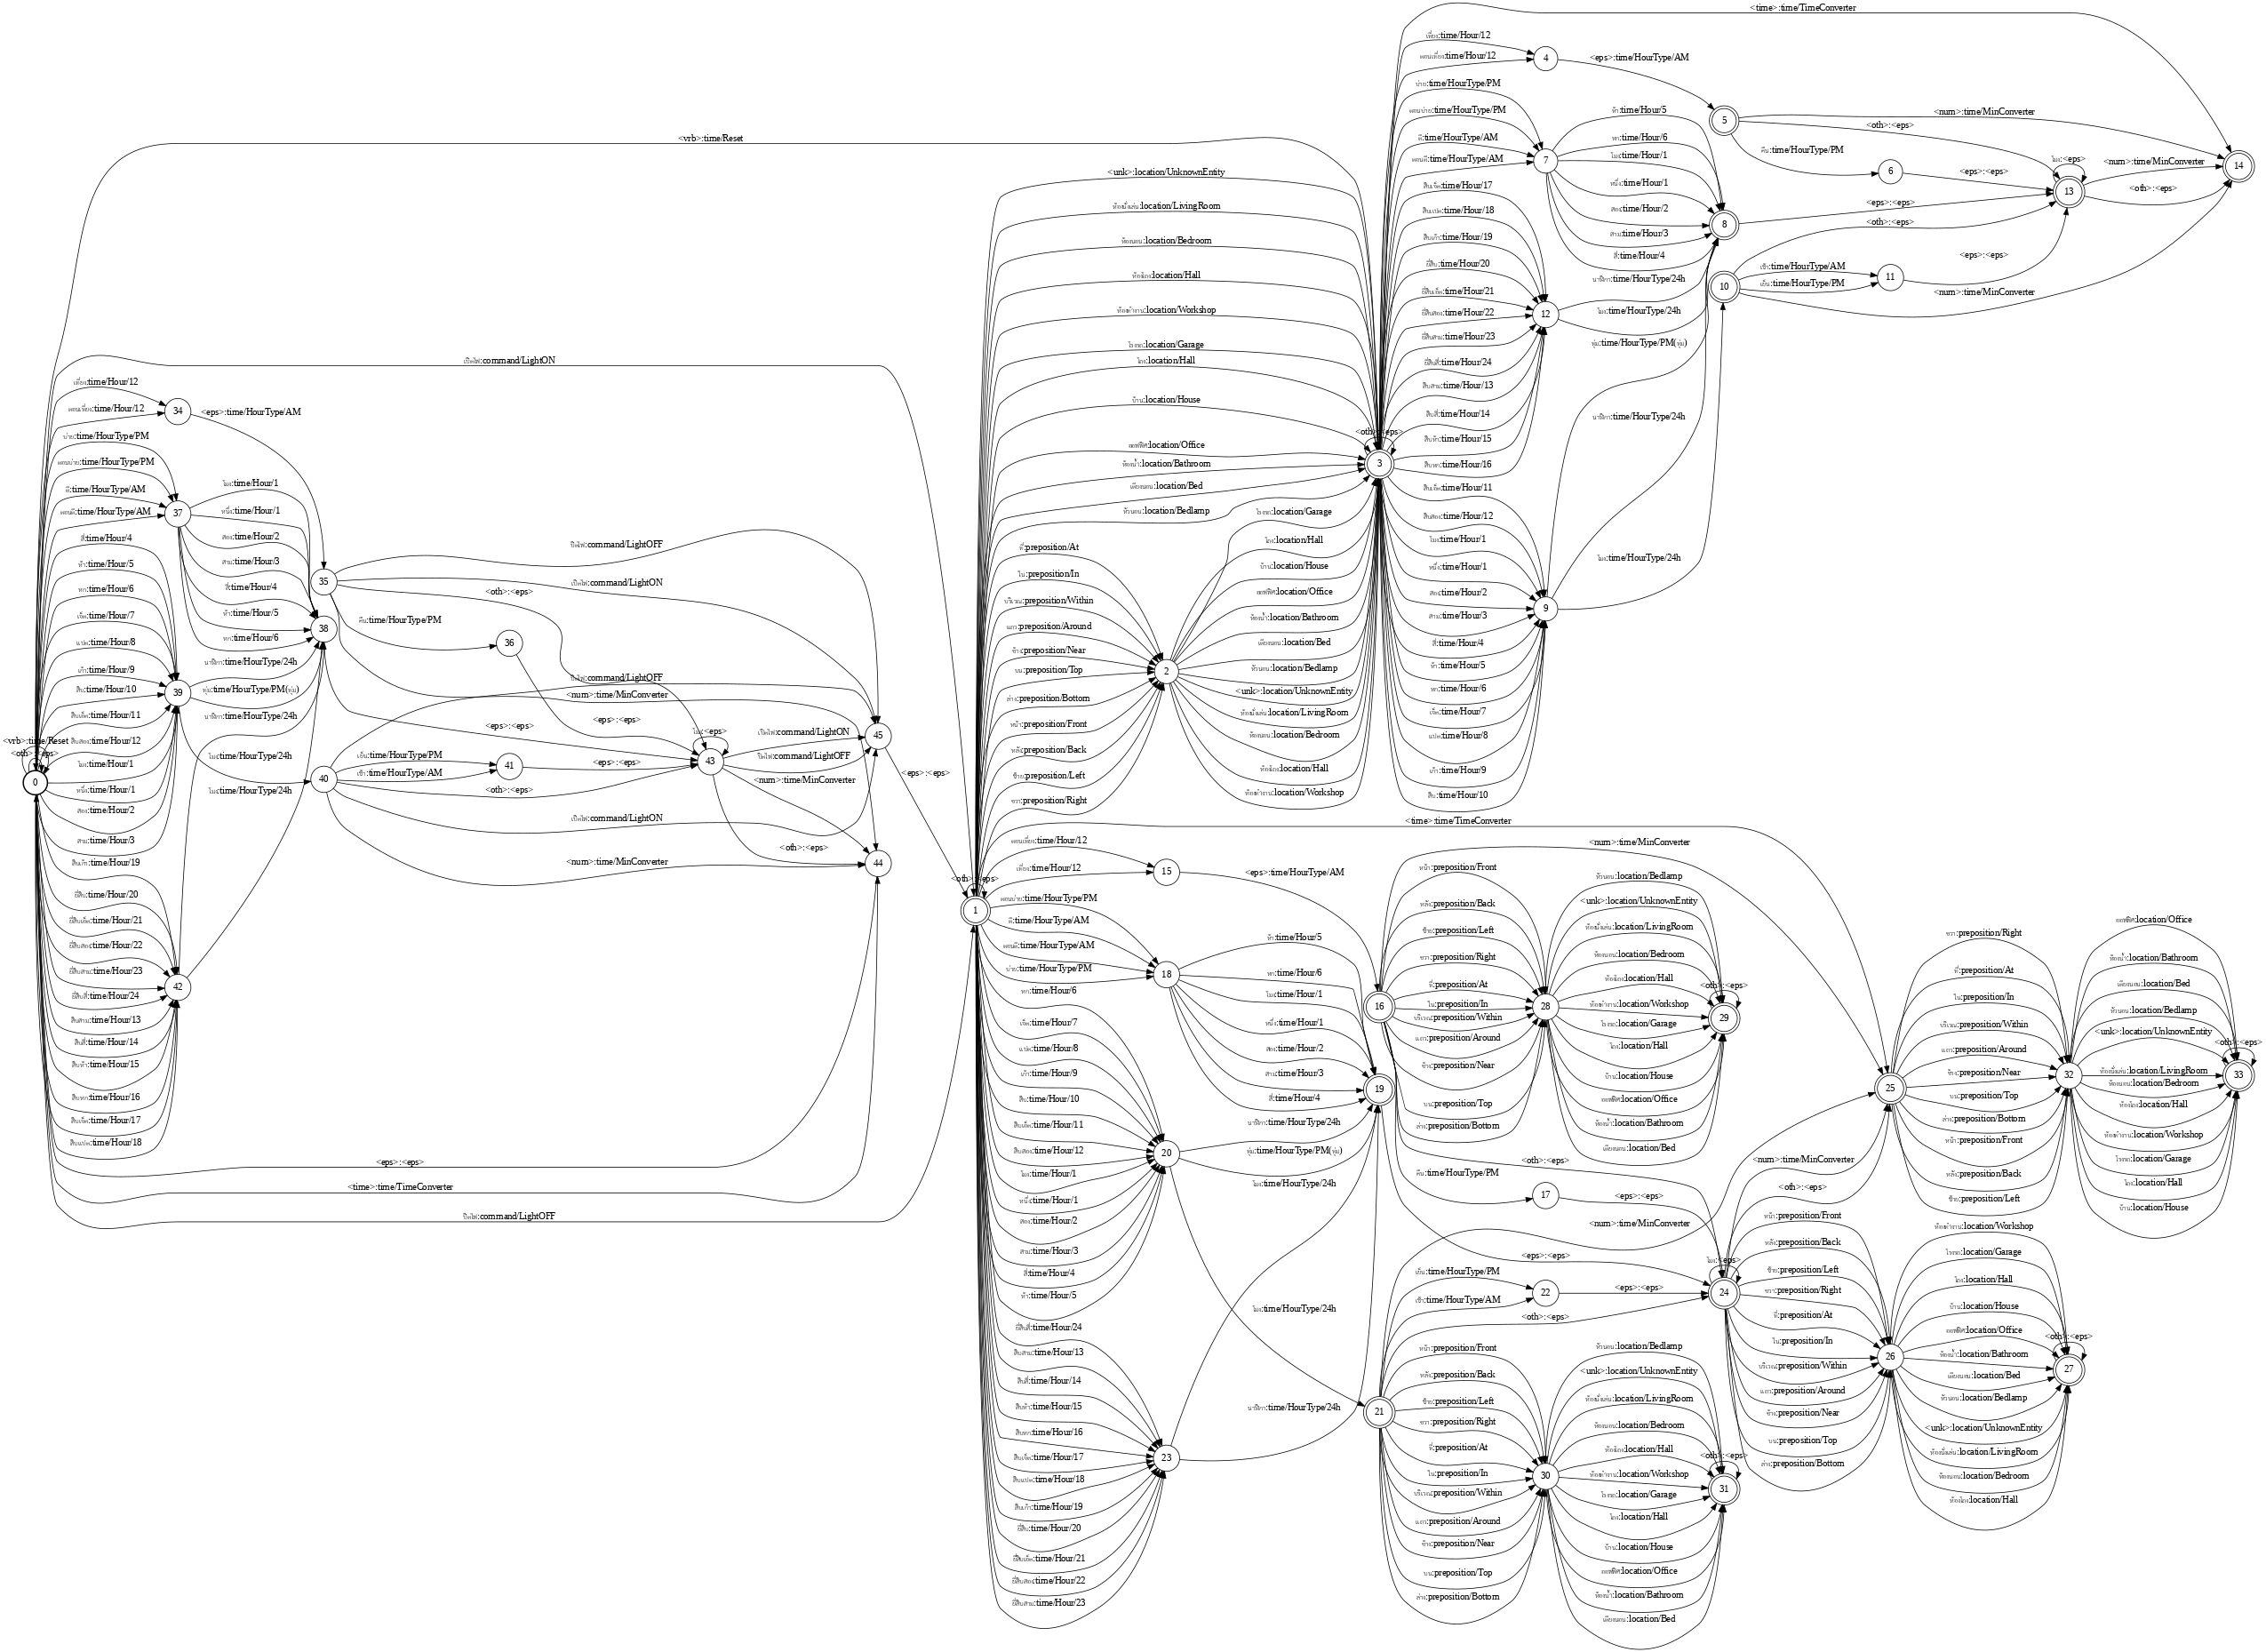

In [ ]:
# Building basline wfst
state_table = pn.SymbolTable()
action_table = pn.SymbolTable()

builder = LightNLUWFSTBuilder()
builder.add_symbols_to_table(state_table, action_table)

F = pn.Fst()
start_state = F.add_state()
F.set_start(start_state)
F, (current_state, intent_state) = builder.build(state_table, action_table, F, start_state)

# Append Time component to basline wfst
start_state = F.start()
builder = TimeWFSTBuilder()
builder.add_symbols_to_table(state_table, action_table)
F, (current_state, final_states) = builder.build(state_table, action_table, F, current_state, with_Final=True)
F, (current_state, final_states) = builder.build(state_table, action_table, F, intent_state, with_Final=True, with_verb=False, with_location_postfix=True)
F, (current_state, final_states) = builder.build(state_table, action_table, F, start_state, with_Final=False)
F.add_arc(current_state, pn.Arc(state_table.find('<eps>'), action_table.find('<eps>'), None, start_state))
verb_time_connector = F.add_state()
for state in final_states:
  F.add_arc(state, pn.Arc(state_table.find('ปิดไฟ'), action_table.find('command/LightOFF'), None, verb_time_connector))
  F.add_arc(state, pn.Arc(state_table.find('เปิดไฟ'), action_table.find('command/LightON'), None, verb_time_connector))
F.add_arc(verb_time_connector, pn.Arc(state_table.find('<eps>'), action_table.find('<eps>'), None, intent_state))

# Visualizing wfst
F.draw('tmp.dot', portrait=True)
check_call(['dot','-Tpng','-Gdpi=300','tmp.dot','-o','tmp.png'])
Image(filename='tmp.png')

In [ ]:
def postproessing_command(command_v1, command_v2):
  time_v1, time_v2 = command_v1.get('time', None), command_v2.get('time', None)
  if time_v1 and not time_v2:
    return command_v1
  if time_v2 and not time_v1:
    return command_v2
  return command_v1

def hourmin_to_time(input_dict):

  if input_dict.get('hour', None):
    hour = int(input_dict.get('hour'))
    minute = 0 if not input_dict.get('minute', None) else int(input_dict.get('minute'))
    hour_type = '24h' if not input_dict.get('hour_type', None) else str(input_dict.get('hour_type'))

    if hour_type == 'PM':
      hour += 12
    if hour_type == 'PM(ทุ่ม)':
      hour += 18
    time_object = time(hour, minute, 0)
    current_date = datetime.now().date()
    datetime_object = datetime.combine(current_date, time_object)
    input_dict["time"] = thai_strftime(datetime_object, "%H:%M")

  if input_dict.get('hour', None): del input_dict['hour']
  if input_dict.get('hour_type', None): del input_dict['hour_type']
  if input_dict.get('minute', None): del input_dict['minute']

  return input_dict

In [ ]:
def traverse(F, doc, verbose=True):
    outputs = []
    machine_command = {}

    current =  F.start()
    for word in doc:
      if verbose:
        print(word, current)

      current_word, current_pos, current_ent = word.text, word.pos_, word.ent_type_
      if state_table.find(current_word) == -1 and current_word != " ":
        oth_arc = None
        state_traversed = False
        for arc in F.arcs(current):
          input_label, output_label = state_table.find(arc.ilabel), action_table.find(arc.olabel)
          if input_label != "<oth>":
            # Condition for traversing "<vrb>" Arc: When the token is unknown and POS Tagging is VERB and not compound verb
            # Action: Either reset time or prevent the algorithm to traversing down time wfst
            if input_label == "<vrb>" and current_pos == "VERB":
              if output_label != "<eps>" and  current_word not in ["รบกวน", "ช่วย", "กรุณา", "ขอ", "ขอให้", "ให้"]:
                if current == F.start():
                  if machine_command.get('time', None): del machine_command['time']
                  if machine_command.get('hour', None): del machine_command['hour']
                  if machine_command.get('hour_type', None): del machine_command['hour_type']
                  if machine_command.get('minute', None): del machine_command['minute']
                outputs.append(output_label)
              current = arc.nextstate
              state_traversed = True

            # Condition for traversing "<unk>" Arc: When the token is unknown and NER component label word as LOCATION
            # Action: Output location intent as "Unknown"
            if input_label == "<unk>" and current_ent == "LOCATION" and current_pos == "NOUN":
              if output_label != "<eps>":
                machine_command["location"] = f"unknown[{current_word}]"
                outputs.append(output_label)
              current = arc.nextstate
              state_traversed = True
            # Condition for traversing "<time>" Arc: When the token is unknown and NER component label word as TIME
            # Action: Convert word to time object
            if input_label == "<time>" and current_ent == "TIME" and current_pos == "NUM":
              if output_label != "<eps>":
                try:
                  machine_command["time"] = thaiword_to_time(current_word)
                except:
                  pass
                outputs.append(output_label)
              current = arc.nextstate
              state_traversed = True
            # Keeping <oth> arc in memory
            if state_table.find(arc.ilabel) == "<oth>":
              oth_arc = arc
        if not state_traversed:
          # Condition for traversing "<oth>" Arc: When the token is unknown
          # Action: Emit Nothing
          if oth_arc is not None:
            if state_table.find(oth_arc.ilabel) == "<oth>":
              current = oth_arc.nextstate
      else:
        for arc in F.arcs(current):
          input_label, output_label = state_table.find(arc.ilabel), action_table.find(arc.olabel)

          if input_label == "<num>" and current_pos == "NUM":
            if output_label != "<eps>":
              machine_command["minute"] = str(thaiword_to_num(current_word))
              outputs.append(output_label)
            current = arc.nextstate

          if input_label == current_word:
            if output_label != "<eps>":
              splitted_output = output_label.split("/")
              if splitted_output[0] == "command":
                machine_command["command"] = splitted_output[1]
              if splitted_output[0] == "location":
                machine_command["location"] = splitted_output[1]
              if splitted_output[0] == "time":
                if splitted_output[1] == "Hour":
                  machine_command["hour"] = splitted_output[2]
                if splitted_output[1] == "HourType":
                  machine_command["hour_type"] = splitted_output[2]
              outputs.append(output_label)
            current = arc.nextstate

      # Skipping epsilon arc
      if len(list(F.arcs(current)))==1 and state_table.find(list(F.arcs(current))[0].ilabel) == "<eps>":
        output_label = action_table.find(list(F.arcs(current))[0].olabel)
        if output_label != "<eps>":
          splitted_output = output_label.split("/")
          if splitted_output[0] == "time":
              if splitted_output[1] == "Hour":
                machine_command["hour"] = splitted_output[2]
              if splitted_output[1] == "HourType":
                machine_command["hour_type"] = splitted_output[2]
        current = list(F.arcs(current))[0].nextstate

    if F.final(current)== pn.Weight("tropical","0") or machine_command.get('command', None)=='LightON':
      command_valid = True
    else:
      command_valid = False
    machine_command = hourmin_to_time(machine_command)

    return machine_command, command_valid

In [ ]:
input = 'ปิดไฟตอนห้าโมงเย็นห้าสิบห้านาทีที่โรงรถด้วยครับ'

print("baseline model........................")
doc=nlp(input)
for word in doc:
  print(word, word.pos_, word.ent_type_)

print("")

command_v1, command_valid = traverse(F, doc)
print("command valid:",str(command_valid))
print("command:",command_v1)
print("")

print("back-off model........................")
doc=nlp_backoff(input)
for word in doc:
  print(word, word.pos_, word.ent_type_)

print("")

command_v2, command_valid = traverse(F, doc)
print("command valid:",str(command_valid))
print("command:",command_v2)

print("")
print("Choosing the best prediction from both model........................")
command = postproessing_command(command_v1, command_v2)
print("command:",command)

baseline model........................
ปิดไฟ NOUN 
ตอน NOUN 
ห้าโมงเย็นห้าสิบห้านาที NUM TIME
ที่ SCONJ 
โรงรถ NOUN 
ด้วย ADP 
ครับ NOUN 

ปิดไฟ 0
ตอน 1
ห้าโมงเย็นห้าสิบห้านาที 1
ที่ 25
โรงรถ 32
ด้วย 33
ครับ 33
command valid: True
command: {'command': 'LightOFF', 'time': '17:55', 'location': 'Garage'}

back-off model........................
ปิดไฟ NOUN 
ตอน NOUN 
ห้า NUM TIME
โมง NOUN TIME
เย็น ADJ TIME
ห้าสิบห้า NUM TIME
นาที NOUN TIME
ที่ SCONJ 
โรงรถ NOUN 
ด้วย ADP 
ครับ NOUN 

ปิดไฟ 0
ตอน 1
ห้า 1
โมง 20
เย็น 21
ห้าสิบห้า 24
นาที 25
ที่ 25
โรงรถ 32
ด้วย 33
ครับ 33
command valid: True
command: {'command': 'LightOFF', 'location': 'Garage', 'time': '17:55'}

Choosing the best prediction from both model........................
command: {'command': 'LightOFF', 'time': '17:55', 'location': 'Garage'}


# Demo Time

In [ ]:
# @title Utils for Demo
def predict_intent_from_string(input):
  doc=nlp(input)
  command_v1, command_valid = traverse(F, doc, verbose=False)
  doc=nlp_backoff(input)
  print("")
  command_v2, command_valid = traverse(F, doc, verbose=False)
  command = postproessing_command(command_v1, command_v2)
  return command,  command_valid

In [ ]:
# @title Simple Intent Detection
# @markdown ### Choose the demo input or writing your own:
text_and_dropdown = '\u0E2A\u0E32\u0E21\u0E17\u0E38\u0E48\u0E21\u0E22\u0E35\u0E48\u0E2A\u0E34\u0E1A\u0E40\u0E2D\u0E47\u0E14\u0E19\u0E32\u0E17\u0E35 \u0E0A\u0E48\u0E27\u0E22\u0E40\u0E1B\u0E34\u0E14\u0E44\u0E1F\u0E42\u0E15\u0E4A\u0E30\u0E2B\u0E31\u0E27\u0E19\u0E2D\u0E19\u0E14\u0E49\u0E27\u0E22\u0E04\u0E23\u0E31\u0E1A' #@param ['พี่ช่วยเปิดไฟหน้าห้องนั่งเล่นช่วงตีสองห้าสิบหกนาทีด้วยครับ', 'ช่วยปิดไฟหน้าบ้านตอนเที่ยงสิบหกนาทีด้วยครับ', 'ตอนเที่ยงสิบหกนาที ช่วยเปิดไฟหน้าห้องนอนเเละก็เติมนำ้ด้วยครับ', 'ฝากเปิดไฟหน้าห้องโถงล่างด้วยครับ ตอนตีห้าสี่สิบห้านาที', 'ฝากปิดไฟห้องนำ้โถงล่างด้วยครับ','ฝากปิดไฟห้องนำ้ด้วยครับ', 'สามทุ่มยี่สิบเอ็ดนาที ช่วยเปิดไฟโต๊ะหัวนอนด้วยครับ', 'ล้างห้องนำ้ตอนห้าโมงเย็นให้ด้วยครับ'] {allow-input: true}

command, command_valid = predict_intent_from_string(text_and_dropdown)
print("Choosing the best prediction from both model........................")
print("command valid:",str(command_valid))
print("command:",command)


Choosing the best prediction from both model........................
command valid: True
command: {'command': 'LightON', 'location': 'Bedlamp', 'time': '21:21'}
